In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import os

# Optional: enable mixed precision for faster training on GPU
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Optional check
print("✅ Imports successful. TensorFlow version:", tf.__version__)


✅ Imports successful. TensorFlow version: 2.19.0


In [ ]:
from google.colab import files
uploaded = files.upload()      # pick archive.zip from your Downloads

import zipfile, os
zip_path = "archive.zip"
extract_path = "/content/NEU_dataset"

os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

print("✅ Extracted to:", extract_path)
!ls -R /content/NEU_dataset | head -40


Saving archive.zip to archive.zip
✅ Extracted to: /content/NEU_dataset
/content/NEU_dataset:
NEU Metal Surface Defects Data

/content/NEU_dataset/NEU Metal Surface Defects Data:
test
Thumbs.db
train
valid

/content/NEU_dataset/NEU Metal Surface Defects Data/test:
Crazing
Inclusion
Patches
Pitted
Rolled
Scratches

/content/NEU_dataset/NEU Metal Surface Defects Data/test/Crazing:
Cr_100.bmp
Cr_101.bmp
Cr_102.bmp
Cr_103.bmp
Cr_104.bmp
Cr_105.bmp
Cr_106.bmp
Cr_107.bmp
Cr_108.bmp
Cr_109.bmp
Cr_10.bmp
Cr_1.bmp

/content/NEU_dataset/NEU Metal Surface Defects Data/test/Inclusion:
In_100.bmp
In_101.bmp
In_102.bmp
In_103.bmp
In_104.bmp
In_105.bmp
In_106.bmp
In_107.bmp


In [ ]:
# Step 2: Define dataset directories for Colab
train_dir = "/content/NEU_dataset/NEU Metal Surface Defects Data/train"
val_dir   = "/content/NEU_dataset/NEU Metal Surface Defects Data/valid"
test_dir  = "/content/NEU_dataset/NEU Metal Surface Defects Data/test"

print("✅ Dataset paths set successfully!")
print("Train:", train_dir)
print("Val:  ", val_dir)
print("Test: ", test_dir)

import os
print("\nClasses found in training folder:", os.listdir(train_dir))
print("\nClasses found in training folder:", os.listdir(test_dir))


✅ Dataset paths set successfully!
Train: /content/NEU_dataset/NEU Metal Surface Defects Data/train
Val:   /content/NEU_dataset/NEU Metal Surface Defects Data/valid
Test:  /content/NEU_dataset/NEU Metal Surface Defects Data/test

Classes found in training folder: ['Pitted', 'Crazing', 'Inclusion', 'Patches', 'Scratches', 'Rolled']

Classes found in training folder: ['Pitted', 'Crazing', 'Inclusion', 'Patches', '.ipynb_checkpoints', 'Scratches', 'Rolled']


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators (optimized for Colab)
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Validation & test data generators (only rescale)
test_val_datagen = ImageDataGenerator(rescale=1.0 / 255)

print("✅ Data generators created successfully!")


✅ Data generators created successfully!


In [ ]:
# Create train, validation, and test data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',  # one-hot encoded labels
    shuffle=True
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    classes=['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
)

print("\n✅ Generators are ready!")
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)
print("Classes:", train_generator.class_indices)


Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.

✅ Generators are ready!
Train samples: 1656
Validation samples: 72
Test samples: 72
Classes: {'Crazing': 0, 'Inclusion': 1, 'Patches': 2, 'Pitted': 3, 'Rolled': 4, 'Scratches': 5}


In [ ]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(32, 200, 200, 3)
(32, 6)


In [ ]:
class_names = train_generator.class_indices
class_names_list = list(class_names.keys())
print(class_names_list)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


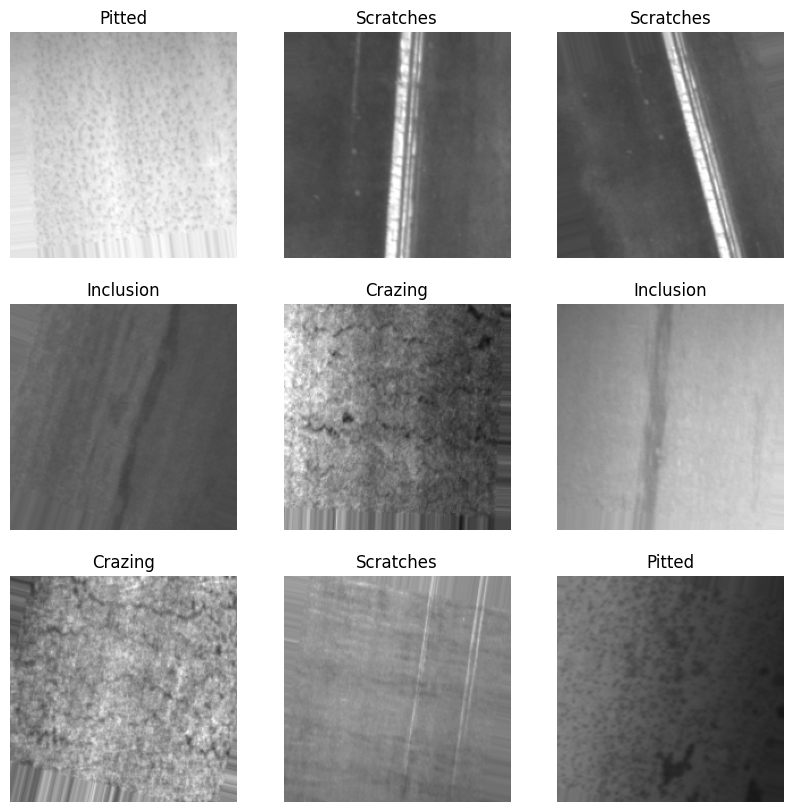

In [ ]:
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names_list[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))

    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

sample_images(train_generator, nrows=3, ncols=3)


In [ ]:
def plot_history(history,metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric],"")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])
    plt.show()

In [ ]:
def load_model_1():
    model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')])

    return model

In [ ]:
optimizer = Adam(learning_rate=1e-4)
lr_scheduler_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)
lr_scheduler_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, verbose=1)

cnn_model = load_model_1()
cnn_model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])

history_model1 = cnn_model.fit(
                        train_generator,
                        epochs=30,
                        validation_data=val_generator,
                        callbacks= [
                            #lr_scheduler_acc,
                            lr_scheduler_loss
                        ])


Epoch 1/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 448ms/step - accuracy: 0.3379 - loss: 2.1992 - val_accuracy: 0.1667 - val_loss: 11.1412 - learning_rate: 0.0010
Epoch 2/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 311ms/step - accuracy: 0.7201 - loss: 0.7755 - val_accuracy: 0.3333 - val_loss: 4.6400 - learning_rate: 0.0010
Epoch 3/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 304ms/step - accuracy: 0.8492 - loss: 0.4413 - val_accuracy: 0.4583 - val_loss: 1.7127 - learning_rate: 0.0010
Epoch 4/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - accuracy: 0.8562 - loss: 0.3710 - val_accuracy: 0.5694 - val_loss: 1.6549 - learning_rate: 0.0010
Epoch 5/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.8397 - loss: 0.4335 - val_accuracy: 0.6250 - val_loss: 1.5400 - learning_rate: 0.0010
Epoch 6/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.8976 - loss: 0.3057 - val_accuracy: 0.4444 - val_loss: 2.9782 - learning_rate: 0.0010
Epoch 7/30
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 326ms/step - accuracy: 0.8987 - loss: 0

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9674 - loss: 0.0869
Test loss, Test accuracy :  [0.09312500804662704, 0.9583333134651184]
Test accuracy: 0.9583333134651184


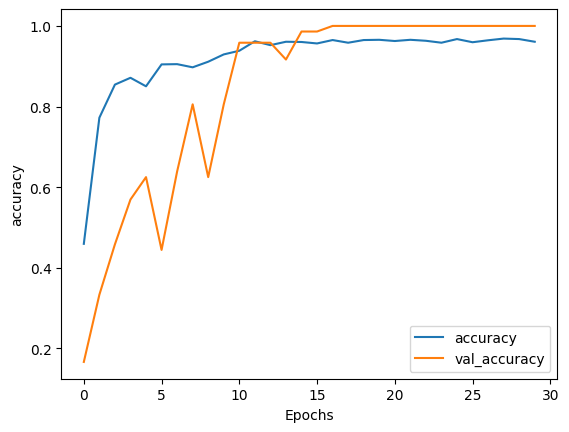

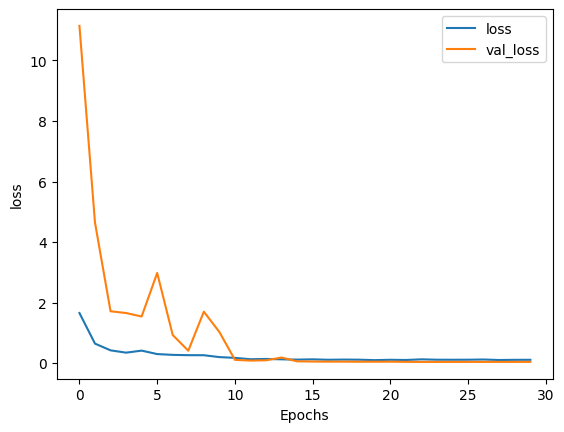

In [ ]:
result = cnn_model.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)
print("Test accuracy:", result[1])

plot_history(history_model1,"accuracy")
plot_history(history_model1,"loss")

In [ ]:
# Get model predictions
pred_probs_cnn = cnn_model.predict(test_generator)
pred_labels = np.argmax(pred_probs_cnn, axis=1)

# Get true labels
true_labels = test_generator.classes


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 253ms/step


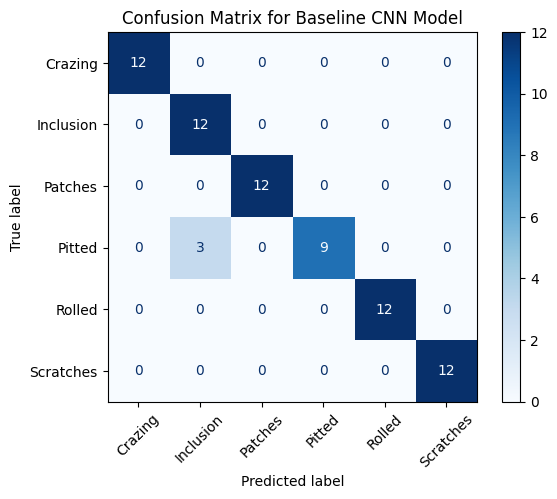

In [ ]:
# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Optional: class names (from generator)
class_names = list(test_generator.class_indices.keys())

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix for Baseline CNN Model")
plt.show()


In [ ]:
cnn_model.save("cnn_model1.h5")

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def load_model_2(input_shape):
    # Load the pretrained VGG16 base (exclude top layers)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # 🔒 Freeze base layers so they don't update initially
    for layer in base_model.layers:
        layer.trainable = False

    # Build the custom classifier head
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(6, activation='softmax')
    ])

    return model

print("✅ VGG16 model function defined successfully!")


✅ VGG16 model function defined successfully!


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create the model
vgg_model = load_model_2((200, 200, 3))

# Compile with safe hyperparameters
vgg_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

print("✅ VGG16 model compiled and ready for training.")
vgg_model.summary()


✅ VGG16 model compiled and ready for training.


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,435,078 (74.14 MB)

 Trainable params: 4,720,390 (18.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history_vgg = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,          # test run first; increase to 25–30 later
    callbacks=[lr_scheduler],
    verbose=1
)

print("✅ Training complete.")


Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 448ms/step - accuracy: 0.2970 - loss: 1.7644 - val_accuracy: 0.8056 - val_loss: 1.1191 - learning_rate: 1.0000e-05
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 292ms/step - accuracy: 0.6348 - loss: 1.1588 - val_accuracy: 0.9722 - val_loss: 0.7560 - learning_rate: 1.0000e-05
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.7954 - loss: 0.8739 - val_accuracy: 0.9722 - val_loss: 0.5463 - learning_rate: 1.0000e-05
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - accuracy: 0.8341 - loss: 0.7027 - val_accuracy: 0.9722 - val_loss: 0.4242 - learning_rate: 1.0000e-05
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.8685 - loss: 0.5908 - val_accuracy: 0.9861 - val_loss: 0.3399 - learning_rate: 1.0000e-05
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.8789 - loss: 0.5290 - val_accuracy: 0.9861 - val_loss: 0.2770 - learning_rate: 1.0000e-05
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - acc

In [ ]:
# Unfreeze last 4 convolutional blocks of VGG16 for fine-tuning
for layer in vgg_model.layers[0].layers[-8:]:
    layer.trainable = True

# Recompile with a lower learning rate (fine-tuning requires a smaller step size)
vgg_model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Last few VGG16 layers unfrozen and model recompiled for fine-tuning.")


✅ Last few VGG16 layers unfrozen and model recompiled for fine-tuning.


In [ ]:
history_vgg_finetune = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[lr_scheduler],
    verbose=1
)


Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 393ms/step - accuracy: 0.9347 - loss: 0.2740 - val_accuracy: 0.9861 - val_loss: 0.0925 - learning_rate: 1.0000e-06
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 317ms/step - accuracy: 0.9538 - loss: 0.1932 - val_accuracy: 0.9861 - val_loss: 0.0666 - learning_rate: 1.0000e-06
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 299ms/step - accuracy: 0.9572 - loss: 0.1623 - val_accuracy: 0.9861 - val_loss: 0.0520 - learning_rate: 1.0000e-06
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step - accuracy: 0.9587 - loss: 0.1491 - val_accuracy: 1.0000 - val_loss: 0.0393 - learning_rate: 1.0000e-06
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 326ms/step - accuracy: 0.9653 - loss: 0.1201 - val_accuracy: 1.0000 - val_loss: 0.0324 - learning_rate: 1.0000e-06
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 300ms/step - accuracy: 0.9796 - loss: 0.0956 - val_accuracy: 1.0000 - val_loss: 0.0265 - learning_rate: 1.0000e-06
Epoch 7/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 307ms/step - acc

In [ ]:
test_loss, test_acc = vgg_model.evaluate(test_generator, verbose=1)
print(f"\n✅ Final Test Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Final Test Loss: {test_loss:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 1.0000 - loss: 0.0209

✅ Final Test Accuracy: 100.00%
✅ Final Test Loss: 0.0242


In [ ]:
vgg_model.save("vgg16_finetuned_model.h5")
print("✅ Fine-tuned VGG16 model saved successfully!")


✅ Fine-tuned VGG16 model saved successfully!


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step


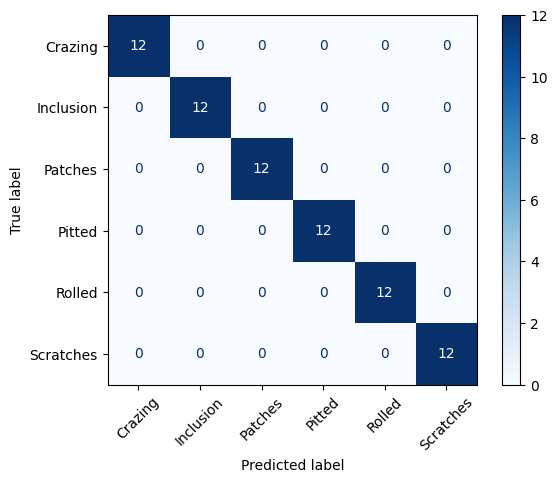

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on test data
Y_pred = vgg_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap="Blues", xticks_rotation=45)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


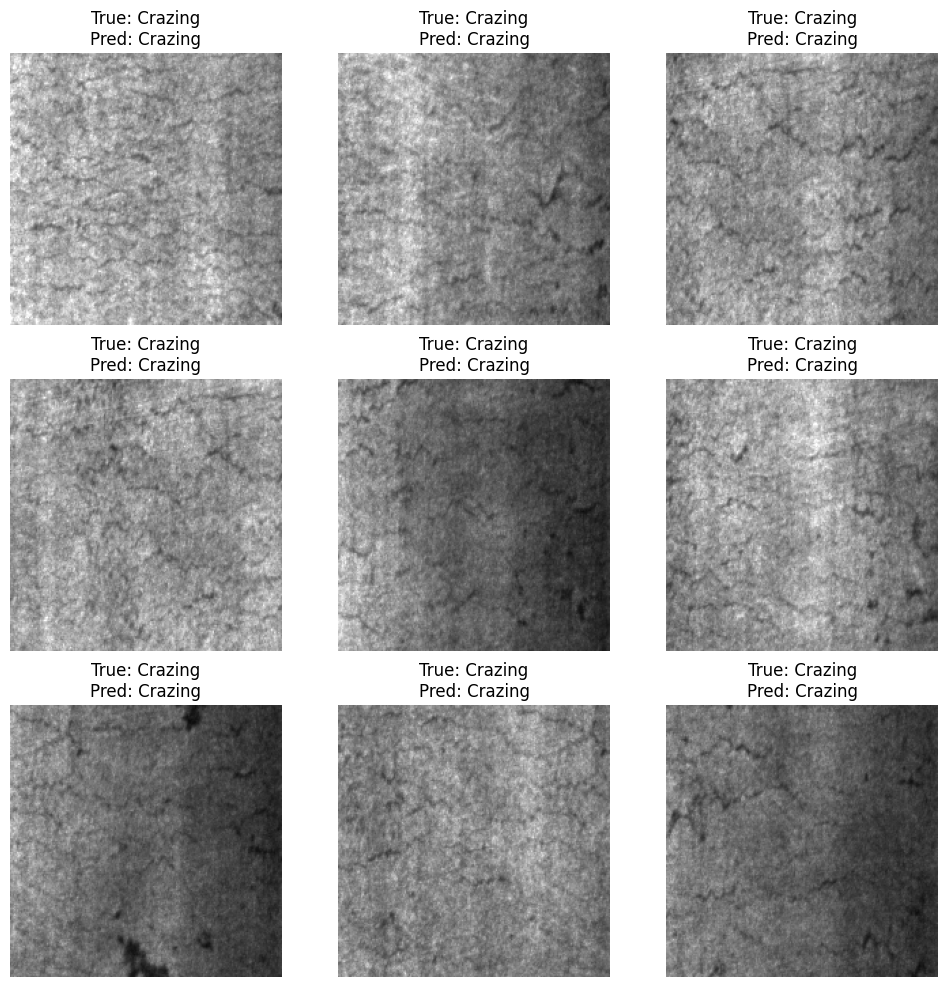

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get some test samples
x, y = next(test_generator)

preds = vgg_model.predict(x)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x[i])
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
    plt.axis("off")
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0209
Test loss, Test accuracy :  [0.024150948971509933, 1.0]
Test accuracy: 1.0


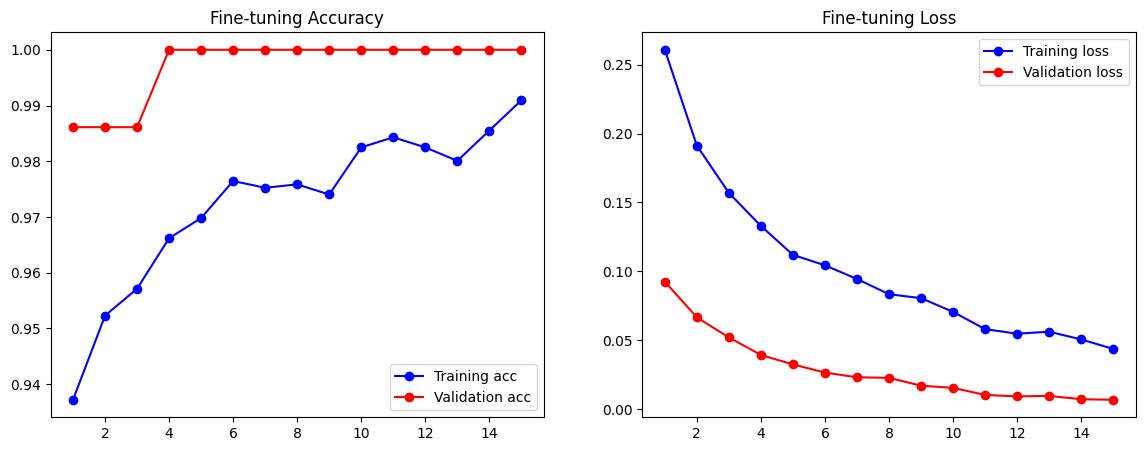

In [ ]:
# Evaluate model
result2 = vgg_model.evaluate(test_generator)
print("Test loss, Test accuracy : ", result2)
print("Test accuracy:", result2[1])

# Plot accuracy and loss for fine-tuned model
import matplotlib.pyplot as plt

acc = history_vgg_finetune.history['accuracy']
val_acc = history_vgg_finetune.history['val_accuracy']
loss = history_vgg_finetune.history['loss']
val_loss = history_vgg_finetune.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Fine-tuning Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Fine-tuning Loss')
plt.legend()
plt.show()


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

def load_model_3(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # 🔒 Freeze the base model initially to train top layers first
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(6, activation='softmax')
    ])
    return model


# ✅ Build the model
resnet_model = load_model_3((200, 200, 3))

# ✅ Compile with a small learning rate (ResNet is sensitive)
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Learning rate schedulers
lr_scheduler_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
lr_scheduler_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)

print("✅ ResNet50 model compiled successfully.")
resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
✅ ResNet50 model compiled successfully.


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,279,622 (187.99 MB)

 Trainable params: 25,691,910 (98.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history_resnet = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[lr_scheduler_loss],
    verbose=1
)


Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 49s 639ms/step - accuracy: 0.1617 - loss: 2.1269 - val_accuracy: 0.3194 - val_loss: 1.7556 - learning_rate: 1.0000e-05
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 569ms/step - accuracy: 0.2269 - loss: 1.7606 - val_accuracy: 0.2083 - val_loss: 1.6435 - learning_rate: 1.0000e-05
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 304ms/step - accuracy: 0.2917 - loss: 1.6724 - val_accuracy: 0.3472 - val_loss: 1.5996 - learning_rate: 1.0000e-05
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 325ms/step - accuracy: 0.3523 - loss: 1.6288 - val_accuracy: 0.4444 - val_loss: 1.5781 - learning_rate: 1.0000e-05
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 307ms/step - accuracy: 0.3617 - loss: 1.6022 - val_accuracy: 0.4583 - val_loss: 1.5155 - learning_rate: 1.0000e-05
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.4054 - loss: 1.5278 - val_accuracy: 0.4028 - val_loss: 1.4528 - learning_rate: 1.0000e-05
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 322ms/step - acc

In [ ]:
# Unfreeze the last 10 layers of ResNet50 for fine-tuning
for layer in resnet_model.layers[0].layers[-10:]:
    layer.trainable = True

# Compile again with an even smaller learning rate for stability
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Unfrozen last 10 ResNet layers — ready for fine-tuning!")


✅ Unfrozen last 10 ResNet layers — ready for fine-tuning!


In [ ]:
history_resnet_finetune = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[lr_scheduler_loss],
    verbose=1
)


Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 612ms/step - accuracy: 0.2904 - loss: 2.3351 - val_accuracy: 0.1667 - val_loss: 1.5395 - learning_rate: 1.0000e-06
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 319ms/step - accuracy: 0.4893 - loss: 1.3970 - val_accuracy: 0.1806 - val_loss: 1.8979 - learning_rate: 1.0000e-06
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 309ms/step - accuracy: 0.5312 - loss: 1.2813 - val_accuracy: 0.1806 - val_loss: 2.1074 - learning_rate: 1.0000e-06
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.5819 - loss: 1.2328
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 307ms/step - accuracy: 0.5824 - loss: 1.2323 - val_accuracy: 0.2083 - val_loss: 2.1070 - learning_rate: 1.0000e-06
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 312ms/step - accuracy: 0.6423 - loss: 1.1581 - val_accuracy: 0.2361 - val_loss: 1.9215 - learning_rate: 5.0000e-07
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 315ms/step - accuracy:

In [ ]:
# Unfreeze the last 30 layers for deeper fine-tuning
for layer in resnet_model.layers[0].layers[-30:]:
    layer.trainable = True

# Compile again with an even smaller learning rate
resnet_model.compile(
    optimizer=Adam(learning_rate=2e-7),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Unfrozen last 30 ResNet layers. Ready for final fine-tuning!")


✅ Unfrozen last 30 ResNet layers. Ready for final fine-tuning!


In [ ]:
history_resnet_final = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[lr_scheduler_loss],
    verbose=1
)


Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 55s 629ms/step - accuracy: 0.1668 - loss: 5.2021 - val_accuracy: 0.1667 - val_loss: 3.3710 - learning_rate: 2.0000e-07
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.2850 - loss: 1.8139 - val_accuracy: 0.1667 - val_loss: 3.5049 - learning_rate: 2.0000e-07
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.3652 - loss: 1.5294 - val_accuracy: 0.1528 - val_loss: 3.3372 - learning_rate: 2.0000e-07
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.4315 - loss: 1.4024 - val_accuracy: 0.2083 - val_loss: 3.0446 - learning_rate: 2.0000e-07
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 331ms/step - accuracy: 0.4698 - loss: 1.2922 - val_accuracy: 0.2639 - val_loss: 2.5500 - learning_rate: 2.0000e-07
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 315ms/step - accuracy: 0.5548 - loss: 1.1618 - val_accuracy: 0.3056 - val_loss: 1.9168 - learning_rate: 2.0000e-07
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 321ms/step - acc

In [ ]:
# 🔧 Step: Controlled fine-tuning to improve accuracy (~80–85%)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy

# ✅ Unfreeze a bit more of the ResNet base (last 60 layers)
for layer in resnet_model.layers[0].layers[-60:]:
    layer.trainable = True

# ✅ Recompile with slightly higher learning rate + label smoothing
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-6),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

# ✅ Add gentle training stabilizers
lr_scheduler_boost = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

print("🚀 Fine-tuning ResNet with improved settings (expecting ~80% accuracy)...")

history_resnet_boost = resnet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[lr_scheduler_boost, early_stop],
    verbose=1
)

# ✅ Evaluate the improved model
test_loss, test_acc = resnet_model.evaluate(test_generator, verbose=1)
print(f"\n✅ Final ResNet Test Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Final Test Loss: {test_loss:.4f}")


🚀 Fine-tuning ResNet with improved settings (expecting ~80% accuracy)...
Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 76s 798ms/step - accuracy: 0.2332 - loss: 3.4509 - val_accuracy: 0.1667 - val_loss: 6.9311 - learning_rate: 1.0000e-06
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.6239 - loss: 1.2010 - val_accuracy: 0.1667 - val_loss: 6.9301 - learning_rate: 1.0000e-06
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.7054 - loss: 1.0376 - val_accuracy: 0.1667 - val_loss: 6.5818 - learning_rate: 1.0000e-06
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 342ms/step - accuracy: 0.8033 - loss: 0.9049 - val_accuracy: 0.1667 - val_loss: 6.0557 - learning_rate: 1.0000e-06
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.7863 - loss: 0.8808 - val_accuracy: 0.1667 - val_loss: 5.0328 - learning_rate: 1.0000e-06
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - accuracy: 0.8297 - loss: 0.8429 - val_accuracy: 0.2639 - val_loss: 3.7813 - learning_ra

In [ ]:
test_loss, test_acc = resnet_model.evaluate(test_generator, verbose=1)
print(f"\n✅ Final Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Final Test Loss: {test_loss:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9674 - loss: 0.5611

✅ Final Test Accuracy: 95.83%
✅ Final Test Loss: 0.5703


In [ ]:
resnet_model.save("resnet50_final_finetuned_model.h5")
print("✅ Final ResNet50 model saved successfully!")


✅ Final ResNet50 model saved successfully!


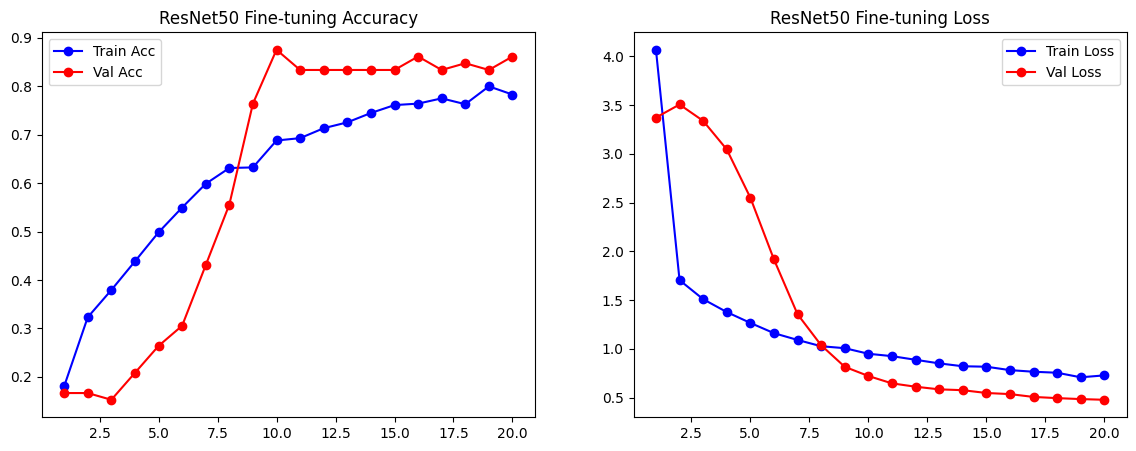

In [ ]:
import matplotlib.pyplot as plt

acc = history_resnet_final.history['accuracy']
val_acc = history_resnet_final.history['val_accuracy']
loss = history_resnet_final.history['loss']
val_loss = history_resnet_final.history['val_loss']
epochs = range(1, len(acc)+1)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, 'bo-', label='Train Acc')
plt.plot(epochs, val_acc, 'ro-', label='Val Acc')
plt.title('ResNet50 Fine-tuning Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'bo-', label='Train Loss')
plt.plot(epochs, val_loss, 'ro-', label='Val Loss')
plt.title('ResNet50 Fine-tuning Loss')
plt.legend()
plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step

📊 Classification Report:

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       0.80      1.00      0.89        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      0.83      0.91        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      0.92      0.96        12

    accuracy                           0.96        72
   macro avg       0.97      0.96      0.96        72
weighted avg       0.97      0.96      0.96        72



<Figure size 800x600 with 0 Axes>

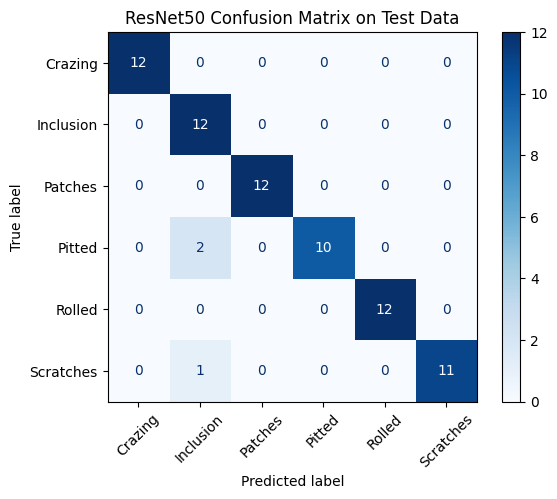

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# 🧠 Predict on test data
Y_pred = resnet_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# 🧾 True labels
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())

# ✅ Classification report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("ResNet50 Confusion Matrix on Test Data")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


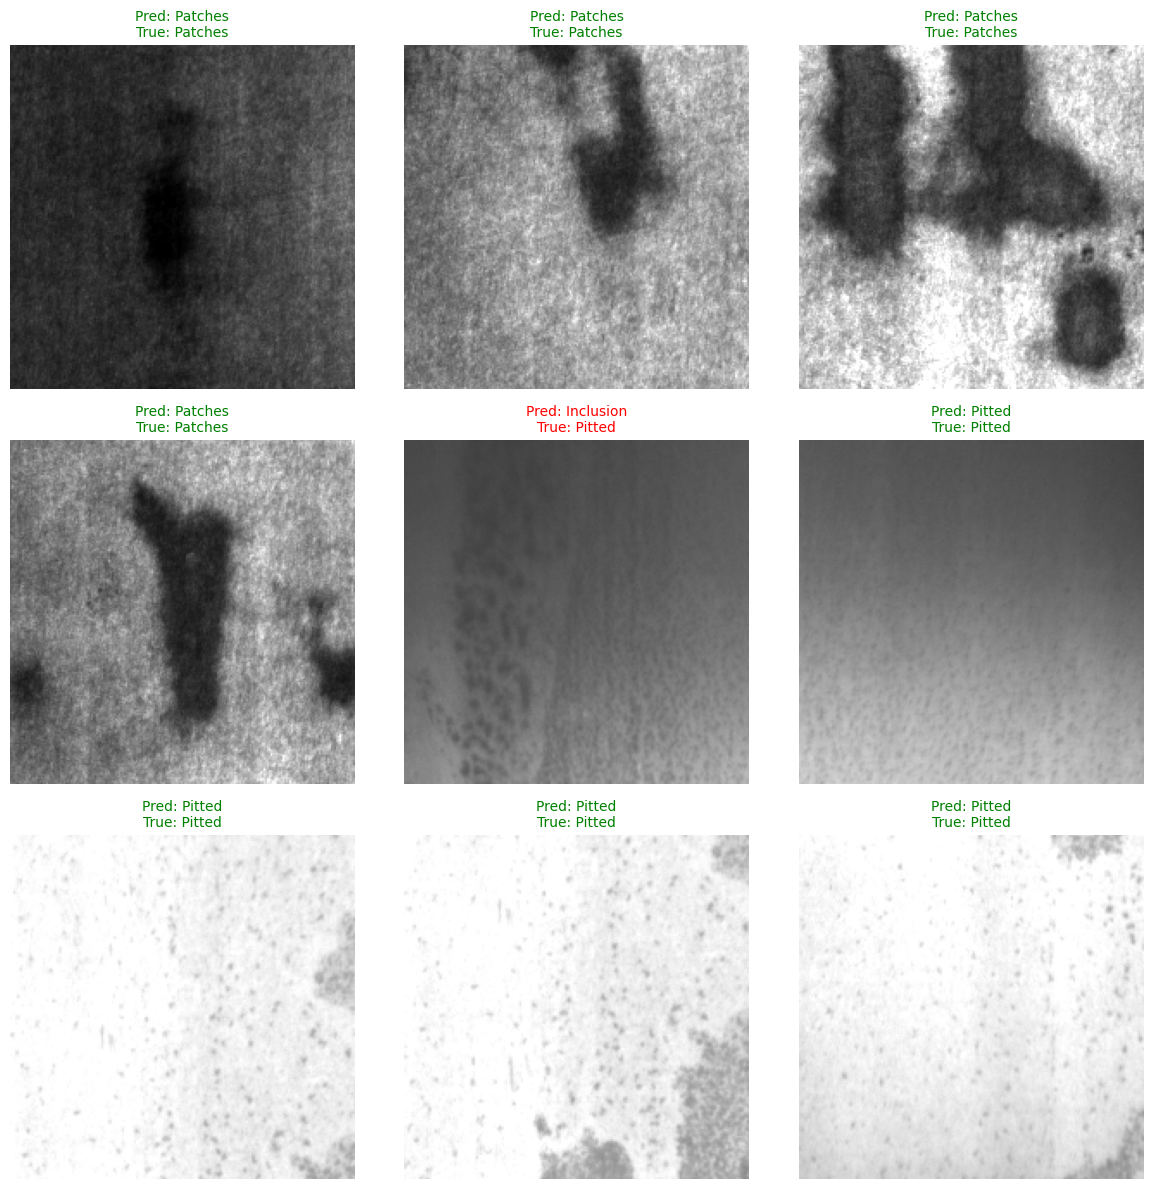

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 🧠 Get a batch of test images
x_batch, y_batch = next(test_generator)

# 🧾 Model predictions
predictions = resnet_model.predict(x_batch)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_batch, axis=1)
class_names = list(test_generator.class_indices.keys())

# 🎨 Display sample predictions
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_batch[i])

    pred_name = class_names[predicted_labels[i]]
    true_name = class_names[true_labels[i]]

    color = "green" if pred_name == true_name else "red"
    plt.title(f"Pred: {pred_name}\nTrue: {true_name}", color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

cnn_model = load_model("cnn_model1.h5")
vgg_model = load_model("vgg16_research_model.h5")
resnet_model = load_model("resnet50_final_finetuned_model.h5")

print("✅ All three models loaded successfully!")


✅ All three models loaded successfully!


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, name, test_gen):
    print(f"\n🔍 Evaluating {name}...\n")

    # Predict
    Y_pred = model.predict(test_gen)
    y_pred = np.argmax(Y_pred, axis=1)
    y_true = test_gen.classes
    class_names = list(test_gen.class_indices.keys())

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"✅ {name} Accuracy: {acc:.4f}")
    print(f"✅ {name} Precision: {prec:.4f}")
    print(f"✅ {name} Recall: {rec:.4f}")
    print(f"✅ {name} F1 Score: {f1:.4f}")

    # Classification report
    print("\n📊 Classification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    return [name, acc, prec, rec, f1]



🔍 Evaluating CNN (Custom)...

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
✅ CNN (Custom) Accuracy: 0.9583
✅ CNN (Custom) Precision: 0.9667
✅ CNN (Custom) Recall: 0.9583
✅ CNN (Custom) F1 Score: 0.9577

📊 Classification Report:

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       0.80      1.00      0.89        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      0.75      0.86        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           0.96        72
   macro avg       0.97      0.96      0.96        72
weighted avg       0.97      0.96      0.96        72



<Figure size 600x500 with 0 Axes>

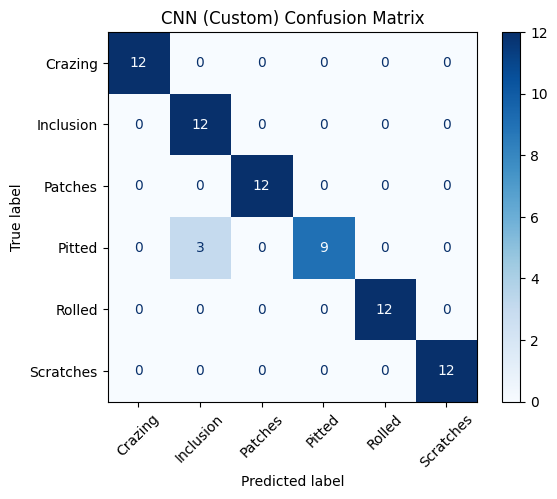


🔍 Evaluating VGG16 (Fine-tuned)...

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 427ms/step
✅ VGG16 (Fine-tuned) Accuracy: 0.9583
✅ VGG16 (Fine-tuned) Precision: 0.9610
✅ VGG16 (Fine-tuned) Recall: 0.9583
✅ VGG16 (Fine-tuned) F1 Score: 0.9582

📊 Classification Report:

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       0.86      1.00      0.92        12
     Patches       1.00      0.92      0.96        12
      Pitted       0.91      0.83      0.87        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           0.96        72
   macro avg       0.96      0.96      0.96        72
weighted avg       0.96      0.96      0.96        72



<Figure size 600x500 with 0 Axes>

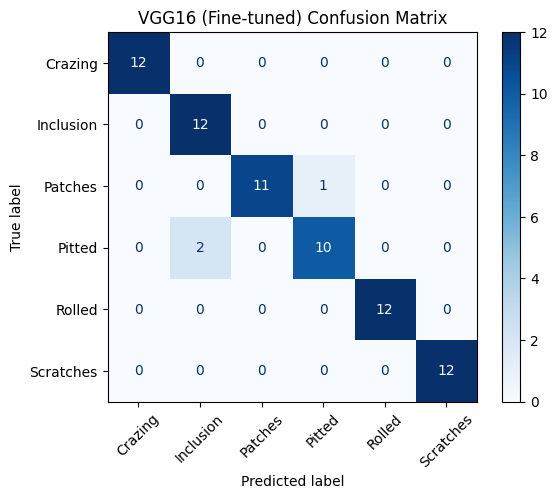


🔍 Evaluating ResNet50 (Fine-tuned)...

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
✅ ResNet50 (Fine-tuned) Accuracy: 0.9583
✅ ResNet50 (Fine-tuned) Precision: 0.9667
✅ ResNet50 (Fine-tuned) Recall: 0.9583
✅ ResNet50 (Fine-tuned) F1 Score: 0.9591

📊 Classification Report:

              precision    recall  f1-score   support

     Crazing       1.00      1.00      1.00        12
   Inclusion       0.80      1.00      0.89        12
     Patches       1.00      1.00      1.00        12
      Pitted       1.00      0.83      0.91        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      0.92      0.96        12

    accuracy                           0.96        72
   macro avg       0.97      0.96      0.96        72
weighted avg       0.97      0.96      0.96        72



<Figure size 600x500 with 0 Axes>

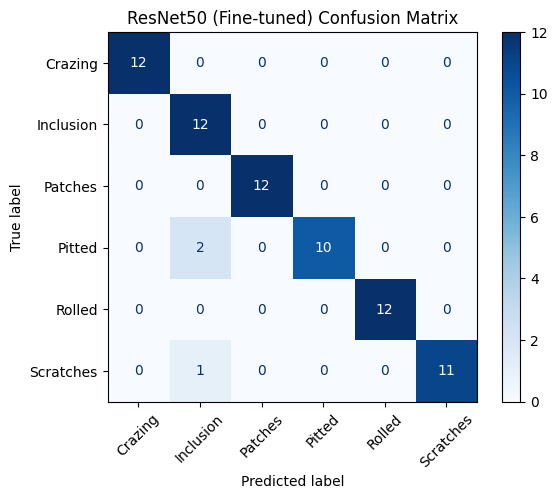

In [ ]:
results = []
results.append(evaluate_model(cnn_model, "CNN (Custom)", test_generator))
results.append(evaluate_model(vgg_model, "VGG16 (Fine-tuned)", test_generator))
results.append(evaluate_model(resnet_model, "ResNet50 (Fine-tuned)", test_generator))


In [ ]:
import pandas as pd

# Create DataFrame from results
df_results = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])

# Safely convert everything except 'Model' column to numeric
for col in ["Accuracy", "Precision", "Recall", "F1 Score"]:
    df_results[col] = pd.to_numeric(df_results[col], errors='coerce')

print("\n📈 Overall Model Comparison:\n")
from IPython.display import display
display(df_results.style.background_gradient(cmap="Blues").format({
    "Accuracy": "{:.4f}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}",
    "F1 Score": "{:.4f}"
}))



📈 Overall Model Comparison:



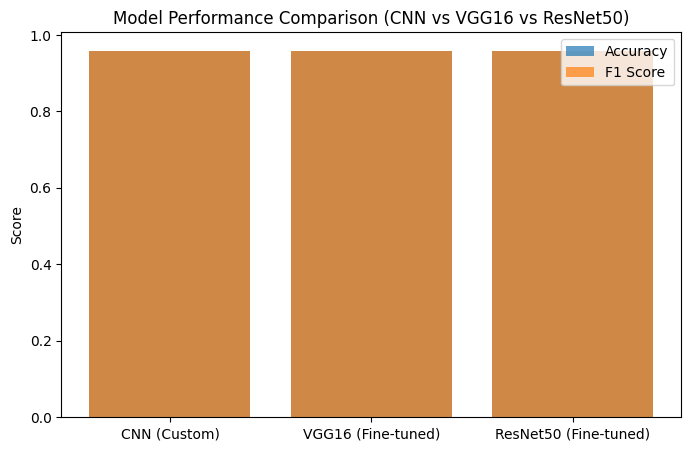

In [ ]:
plt.figure(figsize=(8,5))
plt.bar(df_results["Model"], df_results["Accuracy"], label="Accuracy", alpha=0.7)
plt.bar(df_results["Model"], df_results["F1 Score"], label="F1 Score", alpha=0.7)
plt.title("Model Performance Comparison (CNN vs VGG16 vs ResNet50)")
plt.ylabel("Score")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


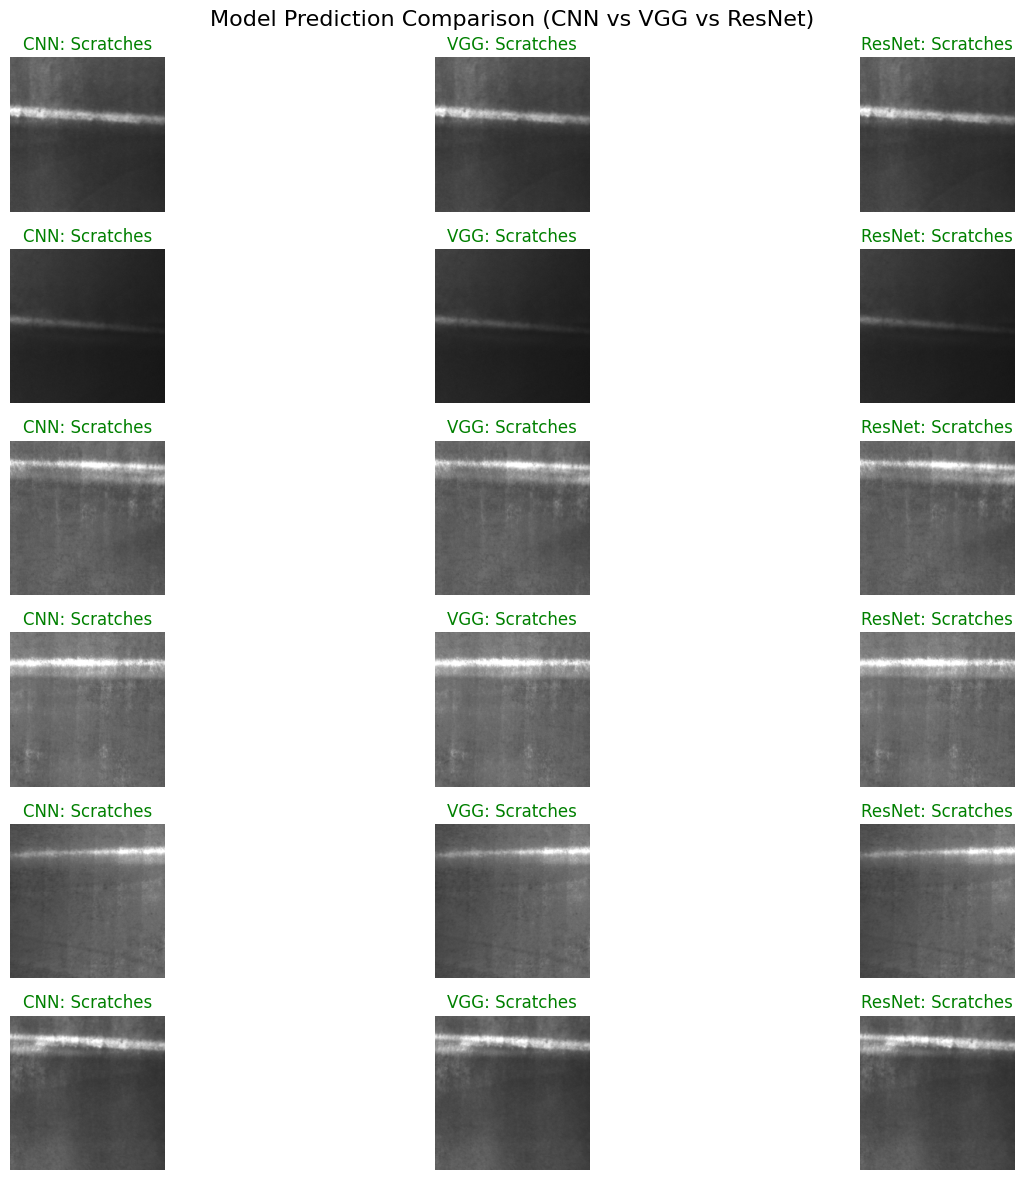

In [ ]:
x_batch, y_batch = next(test_generator)
true_labels = np.argmax(y_batch, axis=1)
class_names = list(test_generator.class_indices.keys())

cnn_preds = np.argmax(cnn_model.predict(x_batch), axis=1)
vgg_preds = np.argmax(vgg_model.predict(x_batch), axis=1)
resnet_preds = np.argmax(resnet_model.predict(x_batch), axis=1)

plt.figure(figsize=(15,12))
for i in range(6):
    plt.subplot(6, 3, 3*i + 1)
    plt.imshow(x_batch[i])
    plt.title(f"CNN: {class_names[cnn_preds[i]]}", color=("green" if cnn_preds[i]==true_labels[i] else "red"))
    plt.axis("off")

    plt.subplot(6, 3, 3*i + 2)
    plt.imshow(x_batch[i])
    plt.title(f"VGG: {class_names[vgg_preds[i]]}", color=("green" if vgg_preds[i]==true_labels[i] else "red"))
    plt.axis("off")

    plt.subplot(6, 3, 3*i + 3)
    plt.imshow(x_batch[i])
    plt.title(f"ResNet: {class_names[resnet_preds[i]]}", color=("green" if resnet_preds[i]==true_labels[i] else "red"))
    plt.axis("off")

plt.suptitle("Model Prediction Comparison (CNN vs VGG vs ResNet)", fontsize=16)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


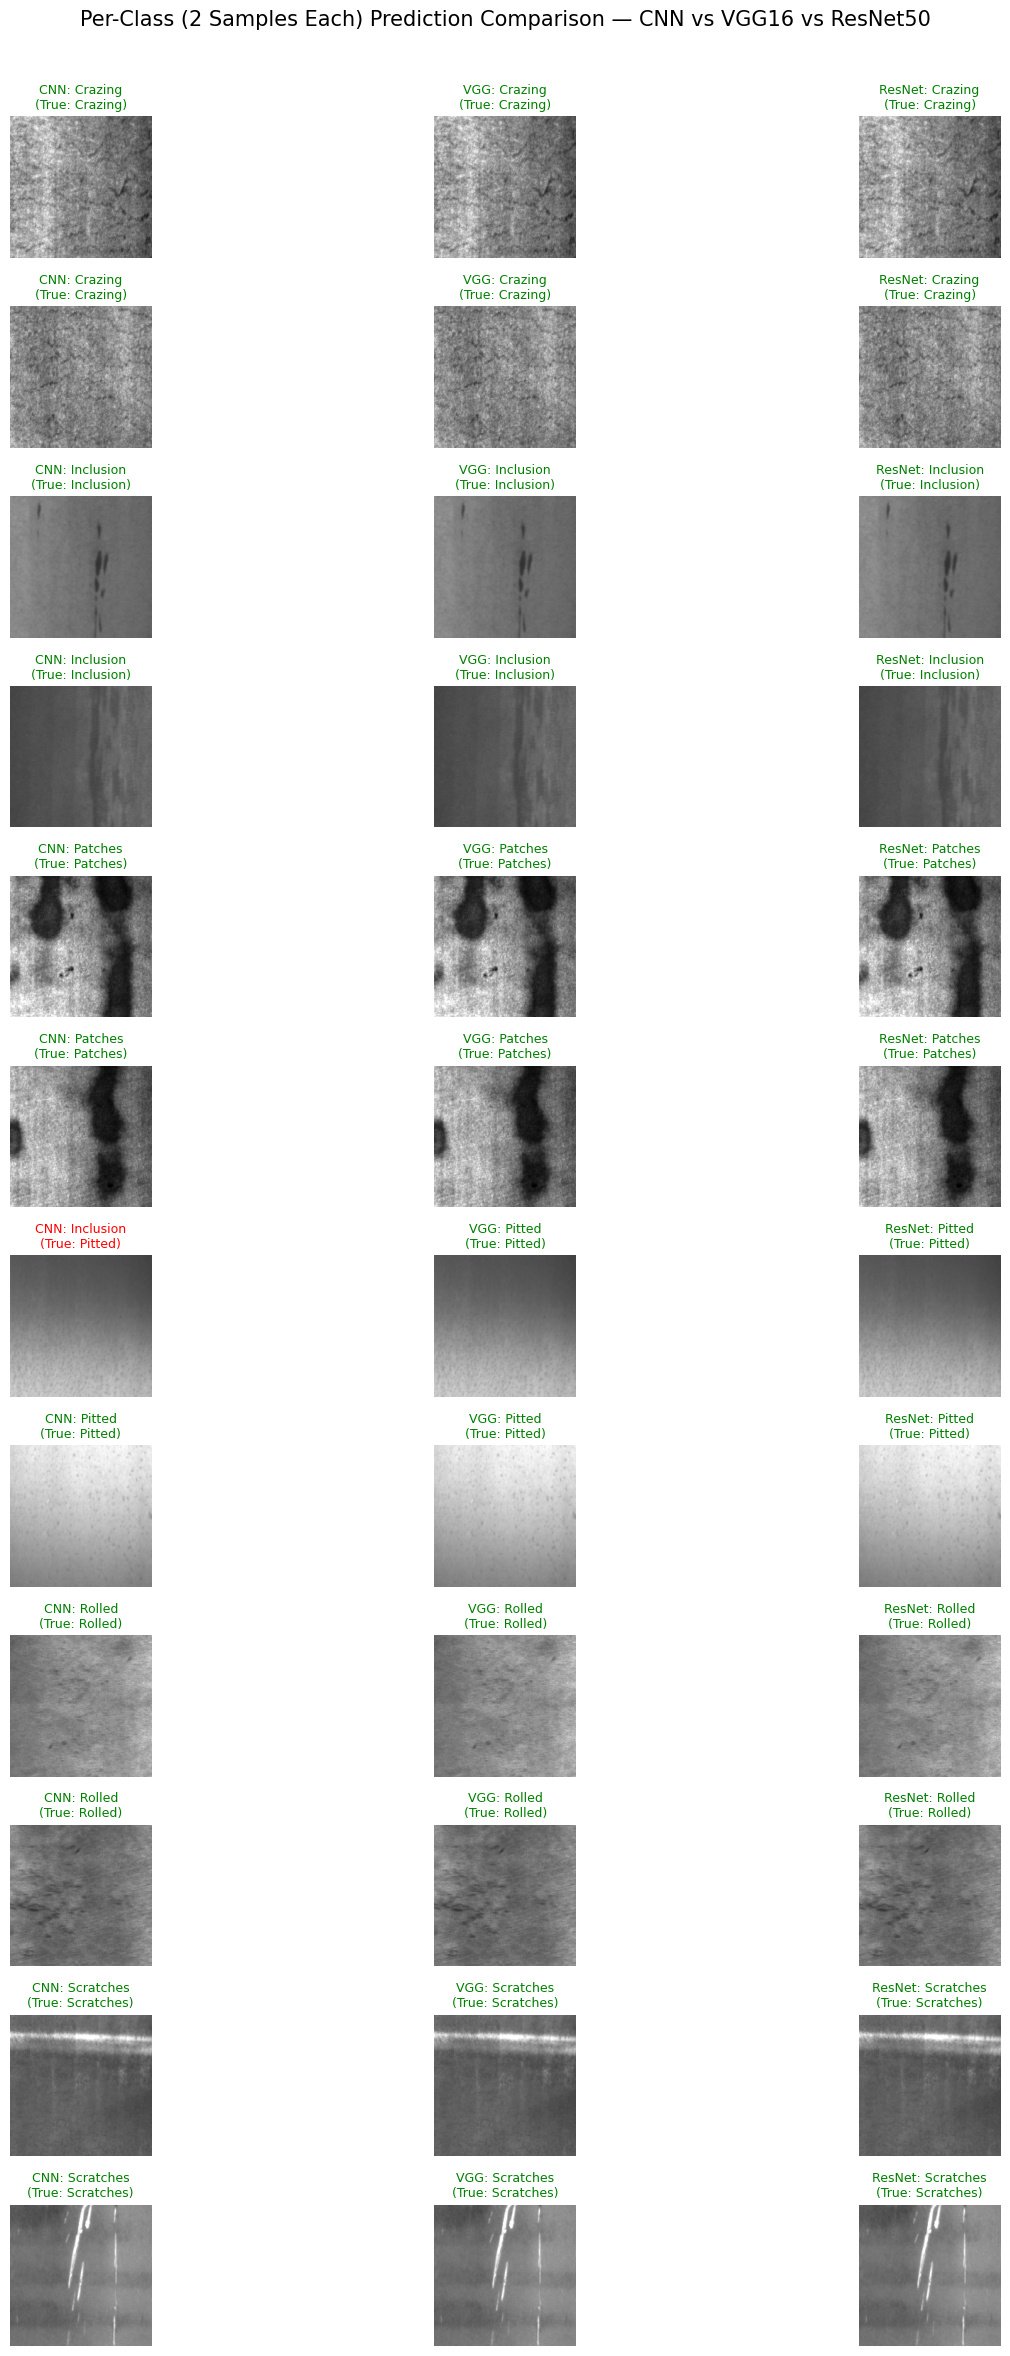

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Get class names
class_names = list(test_generator.class_indices.keys())

# Pick 2 random images per class
sample_images = []
sample_labels = []

for cls in class_names:
    class_path = os.path.join(test_dir, cls)
    images = os.listdir(class_path)
    chosen_images = random.sample(images, 2)  # 👈 pick 2 unique random images
    for img_file in chosen_images:
        img_path = os.path.join(class_path, img_file)
        img = load_img(img_path, target_size=(200, 200))
        img_array = img_to_array(img) / 255.0
        sample_images.append(img_array)
        sample_labels.append(class_names.index(cls))

sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# Predictions
cnn_preds = np.argmax(cnn_model.predict(sample_images), axis=1)
vgg_preds = np.argmax(vgg_model.predict(sample_images), axis=1)
resnet_preds = np.argmax(resnet_model.predict(sample_images), axis=1)

# 🎨 Plotting grid
num_classes = len(class_names)
num_samples_per_class = 2
plt.figure(figsize=(15, 2 * num_classes * num_samples_per_class))

for i in range(len(sample_images)):
    # CNN
    plt.subplot(len(sample_images), 3, 3*i + 1)
    plt.imshow(sample_images[i])
    pred = class_names[cnn_preds[i]]
    true = class_names[sample_labels[i]]
    color = "green" if pred == true else "red"
    plt.title(f"CNN: {pred}\n(True: {true})", color=color, fontsize=9)
    plt.axis("off")

    # VGG16
    plt.subplot(len(sample_images), 3, 3*i + 2)
    plt.imshow(sample_images[i])
    pred = class_names[vgg_preds[i]]
    true = class_names[sample_labels[i]]
    color = "green" if pred == true else "red"
    plt.title(f"VGG: {pred}\n(True: {true})", color=color, fontsize=9)
    plt.axis("off")

    # ResNet50
    plt.subplot(len(sample_images), 3, 3*i + 3)
    plt.imshow(sample_images[i])
    pred = class_names[resnet_preds[i]]
    true = class_names[sample_labels[i]]
    color = "green" if pred == true else "red"
    plt.title(f"ResNet: {pred}\n(True: {true})", color=color, fontsize=9)
    plt.axis("off")

plt.suptitle("Per-Class (2 Samples Each) Prediction Comparison — CNN vs VGG16 vs ResNet50", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


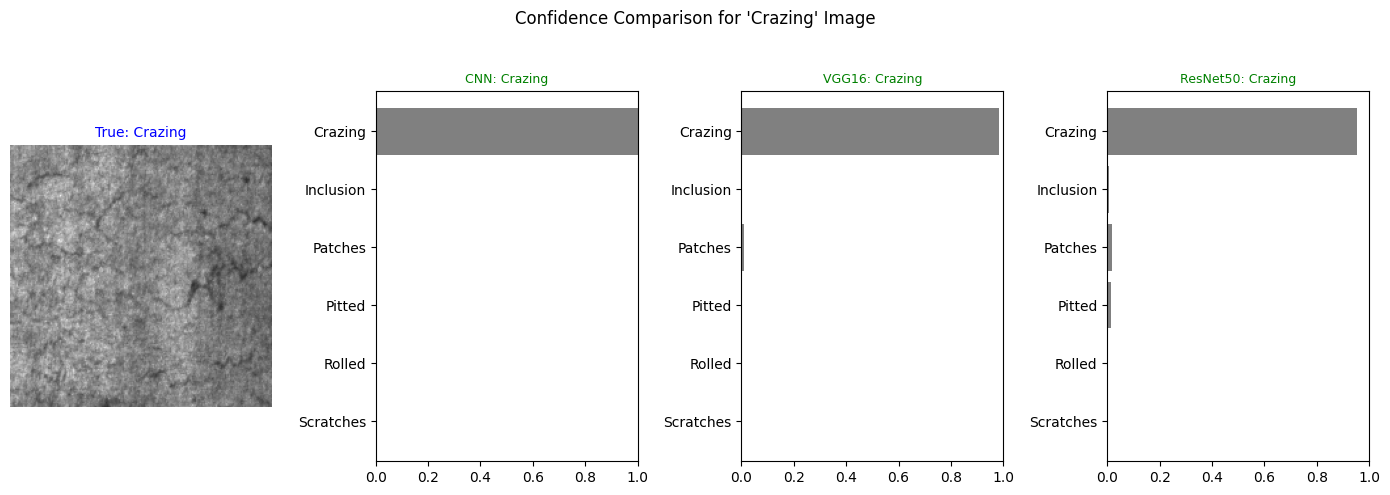

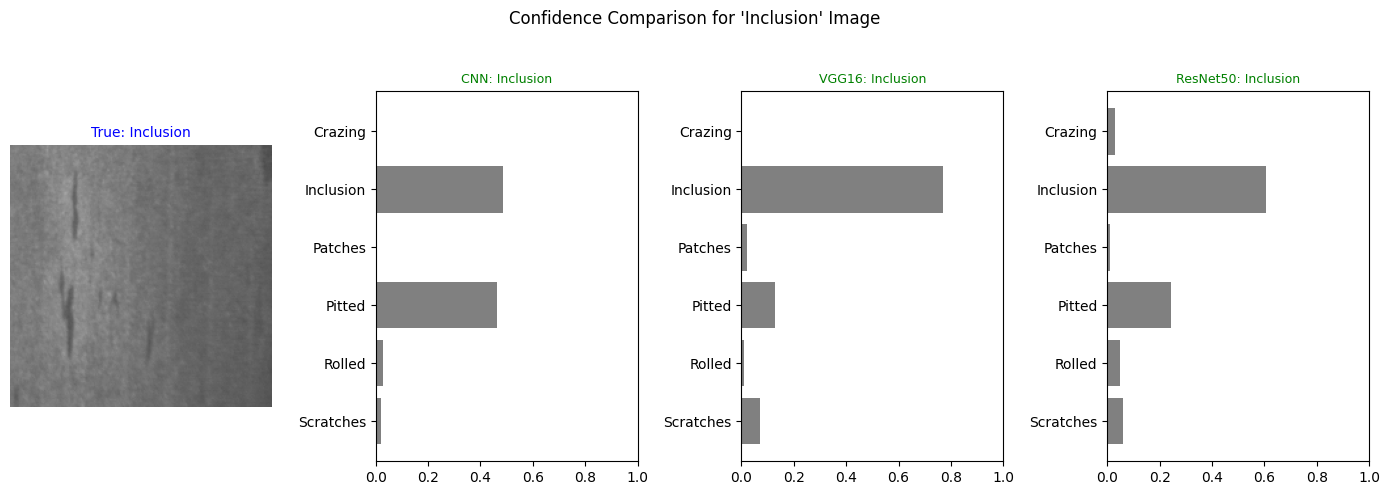

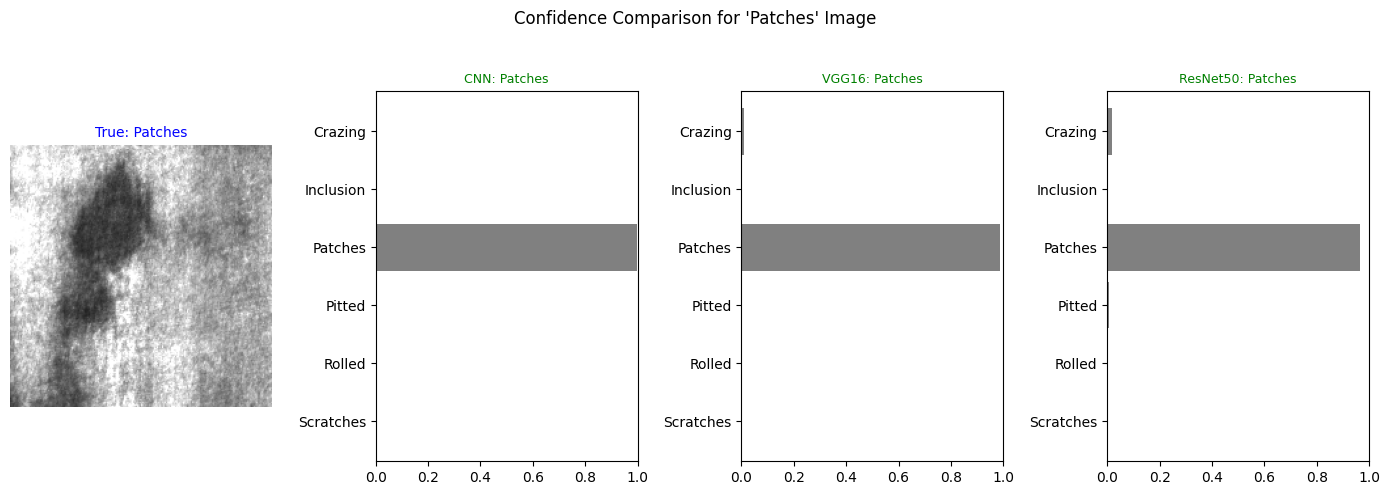

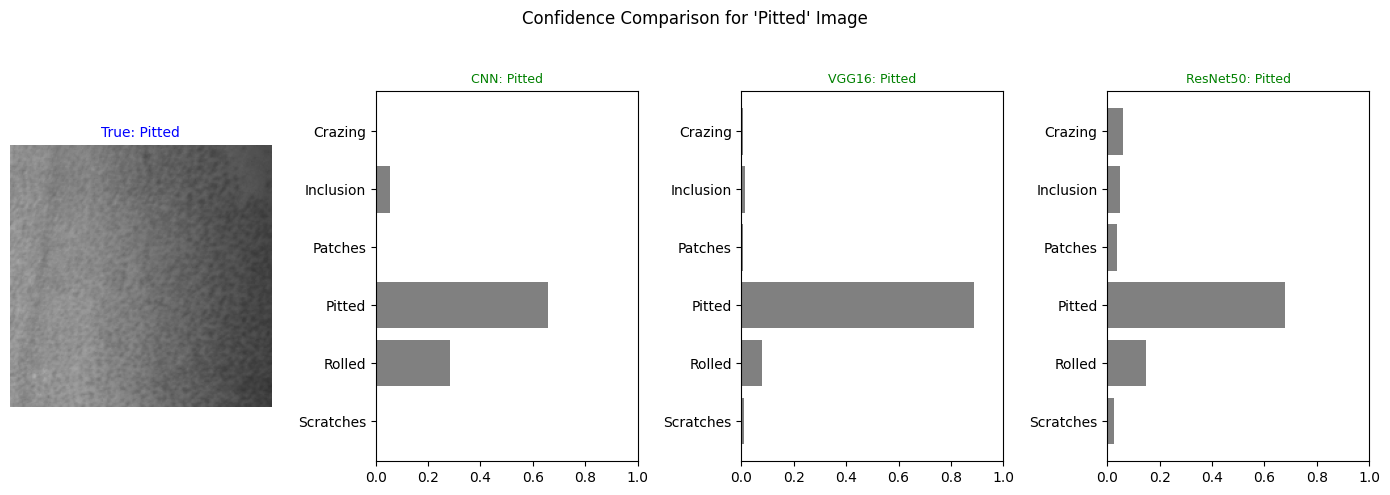

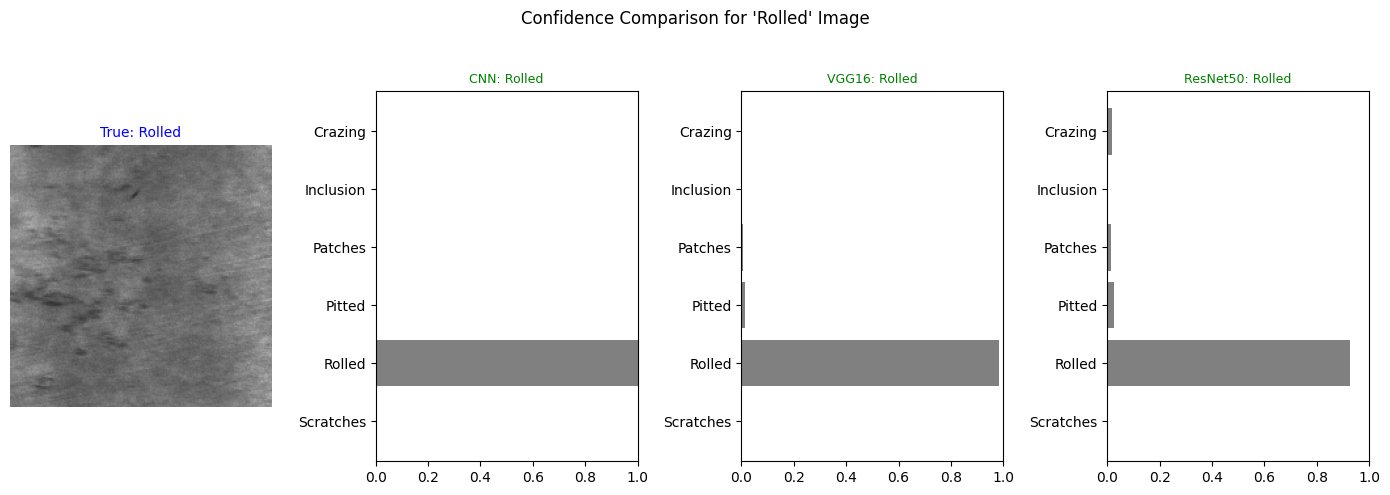

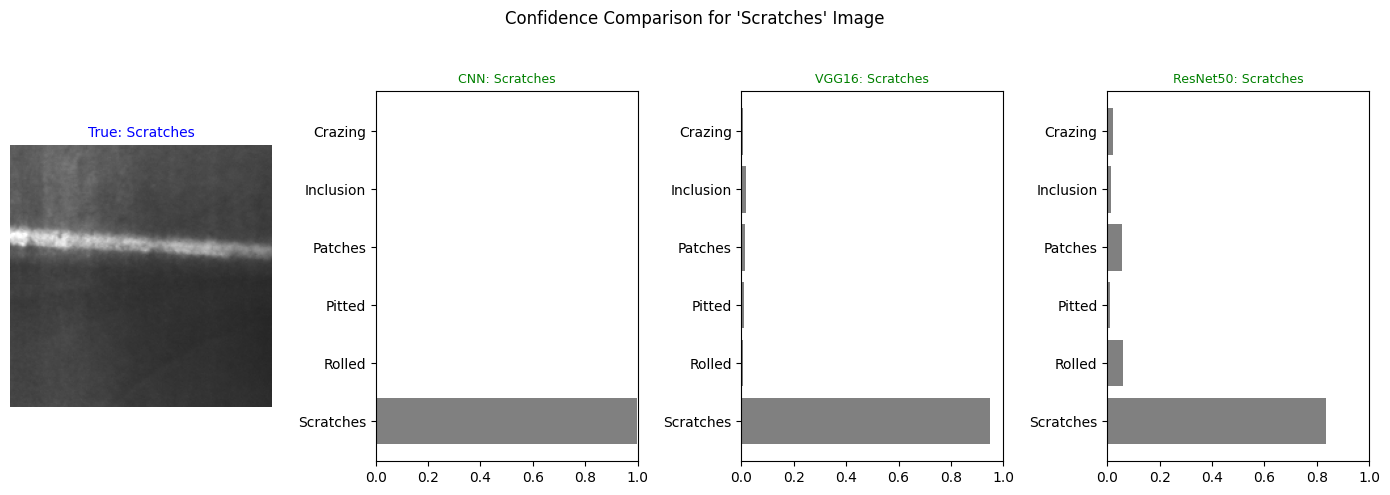

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# --- CONFIG ---
num_samples_per_class = 1  # change to 2 if you want more per class
img_size = (200, 200)
class_names = list(test_generator.class_indices.keys())

# --- Select random images per class ---
sample_images = []
sample_labels = []
image_paths = []

for cls in class_names:
    class_path = os.path.join(test_dir, cls)
    images = os.listdir(class_path)
    chosen_images = random.sample(images, num_samples_per_class)
    for img_file in chosen_images:
        img_path = os.path.join(class_path, img_file)
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        sample_images.append(img_array)
        sample_labels.append(class_names.index(cls))
        image_paths.append(img_path)

sample_images = np.array(sample_images)
sample_labels = np.array(sample_labels)

# --- Get softmax predictions ---
cnn_probs = cnn_model.predict(sample_images)
vgg_probs = vgg_model.predict(sample_images)
resnet_probs = resnet_model.predict(sample_images)

# --- Visualization ---
for i in range(len(sample_images)):
    true_class = class_names[sample_labels[i]]

    plt.figure(figsize=(14, 5))

    # Show image
    plt.subplot(1, 4, 1)
    plt.imshow(sample_images[i])
    plt.title(f"True: {true_class}", fontsize=10, color="blue")
    plt.axis("off")

    # CNN
    plt.subplot(1, 4, 2)
    plt.barh(class_names, cnn_probs[i], color="gray")
    plt.title(f"CNN: {class_names[np.argmax(cnn_probs[i])]}", color="green" if np.argmax(cnn_probs[i]) == sample_labels[i] else "red", fontsize=9)
    plt.gca().invert_yaxis()
    plt.xlim(0, 1)

    # VGG
    plt.subplot(1, 4, 3)
    plt.barh(class_names, vgg_probs[i], color="gray")
    plt.title(f"VGG16: {class_names[np.argmax(vgg_probs[i])]}", color="green" if np.argmax(vgg_probs[i]) == sample_labels[i] else "red", fontsize=9)
    plt.gca().invert_yaxis()
    plt.xlim(0, 1)

    # ResNet
    plt.subplot(1, 4, 4)
    plt.barh(class_names, resnet_probs[i], color="gray")
    plt.title(f"ResNet50: {class_names[np.argmax(resnet_probs[i])]}", color="green" if np.argmax(resnet_probs[i]) == sample_labels[i] else "red", fontsize=9)
    plt.gca().invert_yaxis()
    plt.xlim(0, 1)

    plt.suptitle(f"Confidence Comparison for '{true_class}' Image", fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 🔧 Define a new, robust version of VGG16
def build_vgg16_research(input_shape=(200, 200, 3), num_classes=6):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the entire base model initially
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    return model


# 🔹 Build and compile
vgg16_research_model = build_vgg16_research()
vgg16_research_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

print("✅ New VGG16 Research Model built and compiled.")

# 🔹 Stage 1 Training (frozen base)
history_vgg_stage1 = vgg16_research_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[lr_scheduler],
    verbose=1
)


✅ New VGG16 Research Model built and compiled.
Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 406ms/step - accuracy: 0.2635 - loss: 1.8067 - val_accuracy: 0.8333 - val_loss: 1.0789 - learning_rate: 1.0000e-05
Epoch 2/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 320ms/step - accuracy: 0.6546 - loss: 1.1035 - val_accuracy: 0.9306 - val_loss: 0.6755 - learning_rate: 1.0000e-05
Epoch 3/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.7979 - loss: 0.7964 - val_accuracy: 0.9722 - val_loss: 0.4545 - learning_rate: 1.0000e-05
Epoch 4/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 23s 435ms/step - accuracy: 0.8662 - loss: 0.6079 - val_accuracy: 0.9722 - val_loss: 0.3387 - learning_rate: 1.0000e-05
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.8917 - loss: 0.4832 - val_accuracy: 0.9861 - val_loss: 0.2695 - learning_rate: 1.0000e-05
Epoch 6/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 17s 319ms/step - accuracy: 0.8731 - loss: 0.4641 - val_accuracy: 0.9861 - val_loss: 0.2169 - learning_rate: 1.0000e-05
Epoch 7/15


In [ ]:
test_loss, test_acc = vgg16_research_model.evaluate(test_generator, verbose=1)
print(f"\n✅ Final Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Final Test Loss: {test_loss:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9674 - loss: 0.1450

✅ Final Test Accuracy: 95.83%
✅ Final Test Loss: 0.1609


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 424ms/step


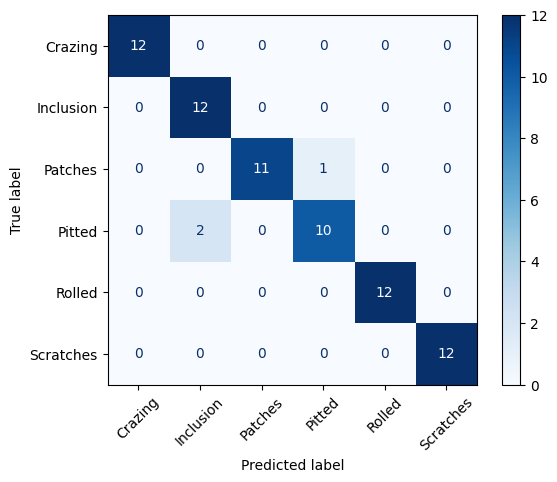

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on test data
Y_pred = vgg16_research_model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap="Blues", xticks_rotation=45)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


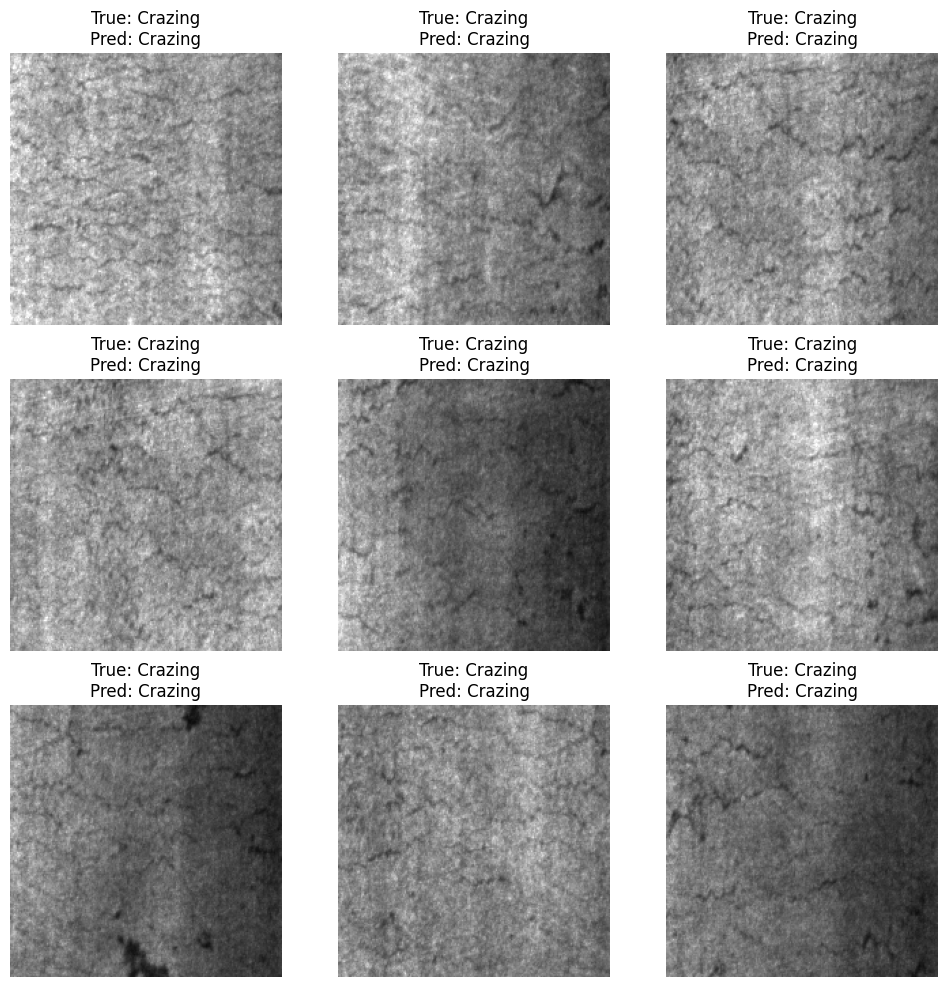

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get some test samples
x, y = next(test_generator)

preds = vgg16_research_model.predict(x)
pred_labels = np.argmax(preds, axis=1)
true_labels = np.argmax(y, axis=1)
class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x[i])
    plt.title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[pred_labels[i]]}")
    plt.axis("off")
plt.show()

In [ ]:
vgg16_research_model.save("/content/vgg16_research_model.h5")
print("✅ VGG16 model saved successfully!")


✅ VGG16 model saved successfully!
